In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SSSSSSBB'
m='TOBS'

# Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.20.1 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [5]:
data_dir='../../Data/Weather'
file_index='SSSSSSBB'

In [6]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [7]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|     7|[40 56 E0 50 00 5...|1970.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|     3|[A0 56 30 55 80 5...|1971.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|    14|[80 54 A0 53 F0 5...|1973.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|    10|[40 56 20 50 30 5...|1974.0|SSSSSSBB|
|    371.9| 33.5333|-113.1667|       TOBS|USC00023852|     8|[30 54 30 54 30 5...|1975.0|SSSSSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



### Create a matrix with all of the series

In [8]:
rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()

T=np.vstack(rows)
shape(T)

(1271, 365)

### Plot two time series
`SNWD` stands for `snow-depth`, which explains why it is zero during the summer

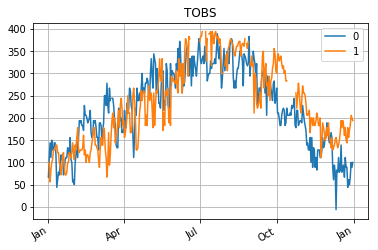

In [9]:
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()
YP.plot(T[16:18].transpose(),fig,ax,title=m)

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

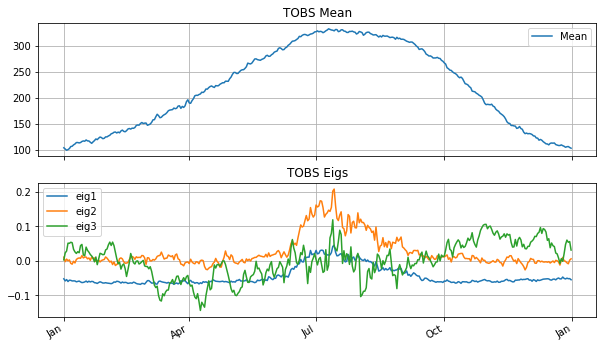

In [10]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

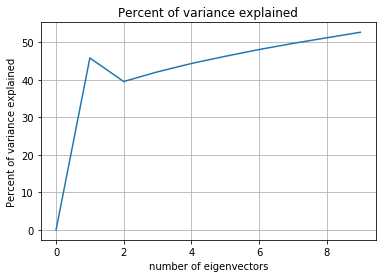

In [11]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [12]:
#print STAT[m]['eigval']

In [13]:
i=10
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
eigen_decomp=Eigen_decomp(None,T[i],Mean,v)
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

residual normalized norm  after mean: 0.0207355881291
residual normalized norm  after mean + top eigs: [ 0.97795237  1.38788754  1.38740966]


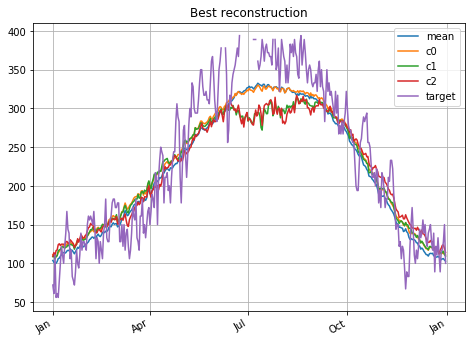

In [14]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [17]:
rows=df.take(3)
L=[]
for row in rows:
    #row_out=decompose(row,Mean,v)
    row_out=decompose(row)
    for field in ('res_mean','res_1','res_2','res_3'):
        print field,':',row_out[field],
    print

res_mean : 0.0201548945404 res_1 : 0.978016460619 res_2 : 1.01428548888 res_3 : 0.996189726677
res_mean : 0.0318087713608 res_1 : 0.995296617418 res_2 : 0.91382828241 res_3 : 0.820106852699
res_mean : 0.0207355881291 res_1 : 0.977952367893 res_2 : 1.38788754473 res_3 : 1.38740965626


In [16]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [19]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
row,=df2.take(1)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
print 'after filter',df3.count()

before filter 1271
after filter 1271


In [20]:
df3=df3.sort(df3.res_3,ascending=True)
rows=df3.take(12)


In [42]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=1, figsize=(25,5)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            if k < 4:
                row=rows[k]
                k+=1
                _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
                    %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
                #print i,j,_title,axes[i,j]
                plot_decomp(row,Mean,v,fig=fig,ax=axes[j],Title=_title,interactive=False)
    return None


In [43]:
df3=df3.filter(df3.res_1<0.4).sort(df3.coeff_1)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+-------------------+-------------------+-------------------+------------------+
|           res_mean|              res_1|              res_2|             res_3|
+-------------------+-------------------+-------------------+------------------+
| 0.0663823240617726| 0.3998170715012825| 0.3620831958611956|0.3240082394543782|
|0.07487188911687259|0.37770218843687364|0.30012454004403205|0.2944755808109263|
|0.07126292332774213|0.37172194357599625| 0.3417144033698524|0.3322861313451753|
|0.08153558807732554| 0.3785914747385987|0.38846697148743287|0.3830323013561963|
+-------------------+-------------------+-------------------+------------------+
only showing top 4 rows



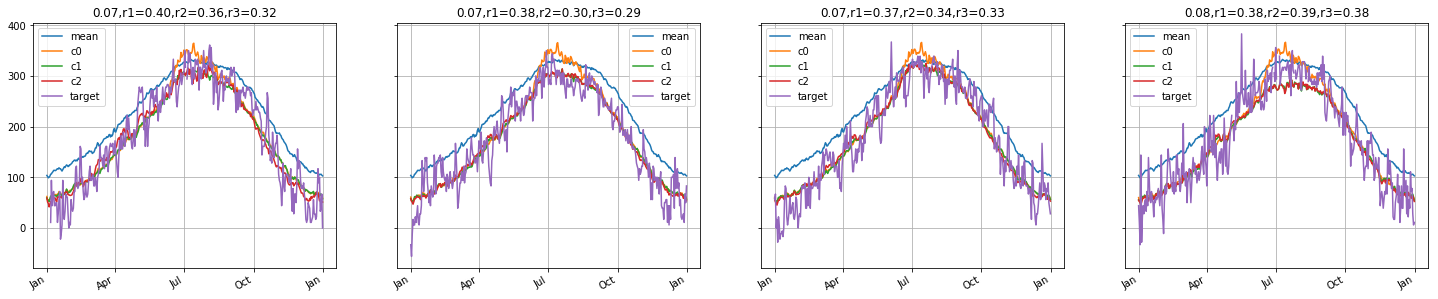

In [44]:
plot_recon_grid(rows)

In [45]:
df3=df3.filter(df3.res_1<0.4).sort(df3.coeff_1,ascending=False)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+------------------+-------------------+-------------------+-------------------+
|          res_mean|              res_1|              res_2|              res_3|
+------------------+-------------------+-------------------+-------------------+
|0.4599444527030833|0.25459494543574046| 0.0729429492001073|0.07274134398454164|
|0.5477635352713006| 0.2817150650628106|0.11550670142430124|0.11526275991773881|
|0.5634220200895197|0.27247423637677964|0.09882593716899184|0.09756567912096431|
|0.4126072267653912| 0.2379988257560919|0.12827794467852427|  0.128274661538754|
+------------------+-------------------+-------------------+-------------------+
only showing top 4 rows



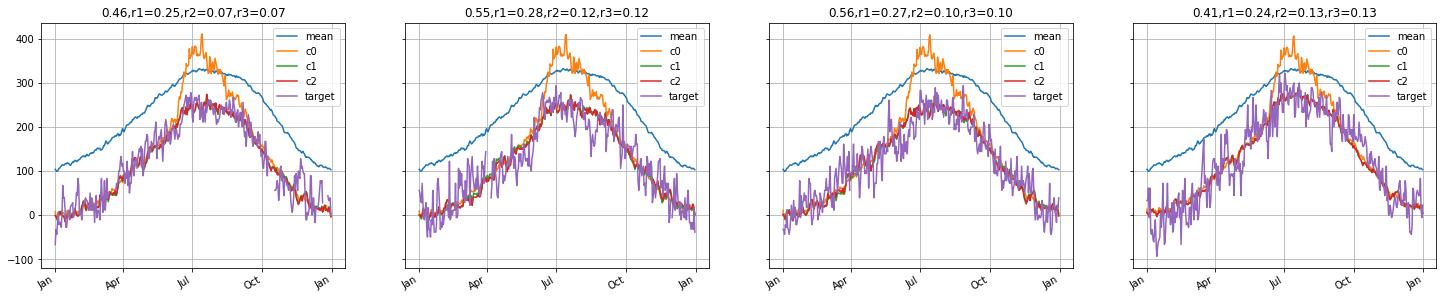

In [46]:
plot_recon_grid(rows)

In [47]:
df3=df3.filter(df3.res_2<0.4).sort(df3.coeff_2)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+-------------------+-------------------+-------------------+-------------------+
|           res_mean|              res_1|              res_2|              res_3|
+-------------------+-------------------+-------------------+-------------------+
|0.26954415109309304|0.27564839695570903|0.26982025831052003| 0.2699288491505255|
|0.43682804014052834|0.33786038295349086| 0.3192334584439767|0.30831943127122435|
|0.31299076040626533|0.20526736970849688|0.22068121239893376|0.22330479599183045|
| 0.5014709064403187| 0.3181001516000303|0.07068288635634673|0.07050803275944424|
+-------------------+-------------------+-------------------+-------------------+
only showing top 4 rows



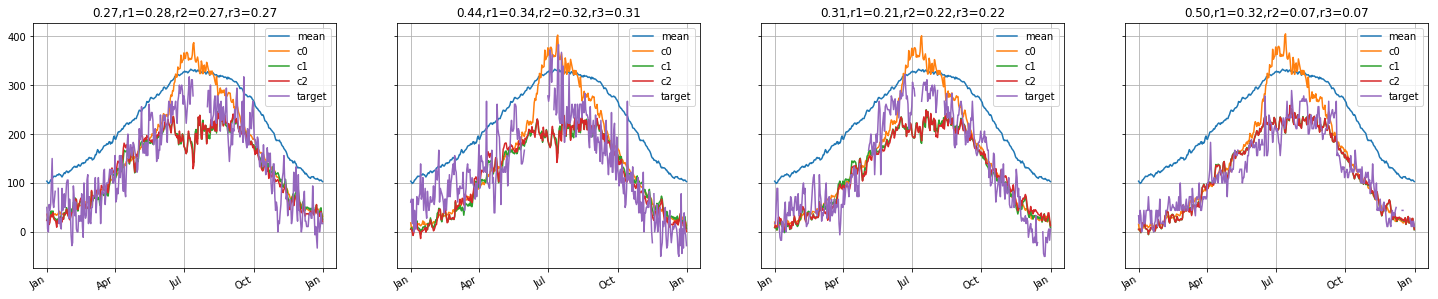

In [48]:
plot_recon_grid(rows)

In [51]:
df3=df3.filter(df3.res_2<0.4).sort(df3.coeff_2,ascending=False)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+-------------------+-------------------+------------------+-------------------+
|           res_mean|              res_1|             res_2|              res_3|
+-------------------+-------------------+------------------+-------------------+
| 0.0984378845683121|0.34704640887392635|0.3268471506742872|0.32375363765652504|
|0.06853630113838854| 0.3867881757697674|0.3582439189295228|0.35679032541541156|
|0.07126292332774213|0.37172194357599625|0.3417144033698524| 0.3322861313451753|
|0.10824305637215702|0.27910578397933034|0.2529072173540939|0.23091810238260016|
+-------------------+-------------------+------------------+-------------------+
only showing top 4 rows



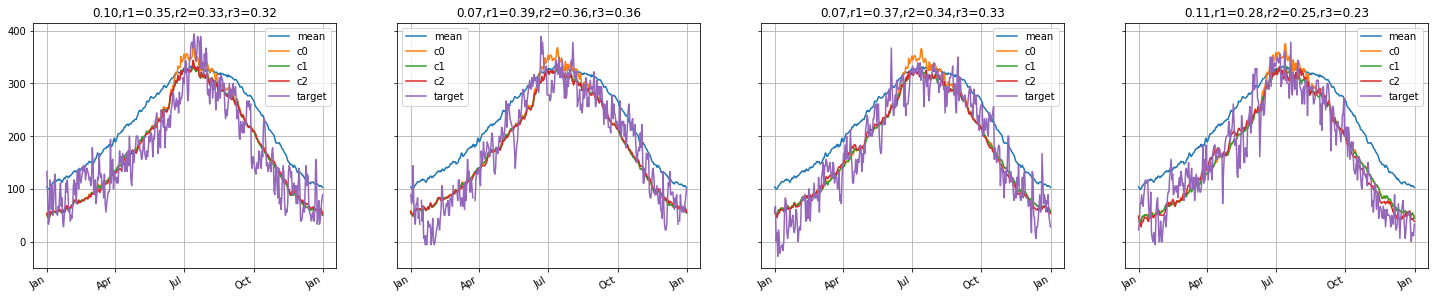

In [52]:
plot_recon_grid(rows)

In [34]:
df3=df3.filter(df3.res_3<0.4).sort(df3.coeff_3)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+-------------------+-------------------+-------------------+-------------------+
|           res_mean|              res_1|              res_2|              res_3|
+-------------------+-------------------+-------------------+-------------------+
|0.14068298287630668|0.35996204094050904|0.28755870450425625|0.22882564242316808|
| 0.0837045160782312| 0.3980937532254723|  0.352343307516763| 0.2710263922294451|
|0.21276274228071818|0.27081458095812655|0.19786902787701868|0.16654249848576141|
| 0.1501357300310153| 0.3082285761208848|0.26343379163697883| 0.2250157141635015|
+-------------------+-------------------+-------------------+-------------------+
only showing top 4 rows



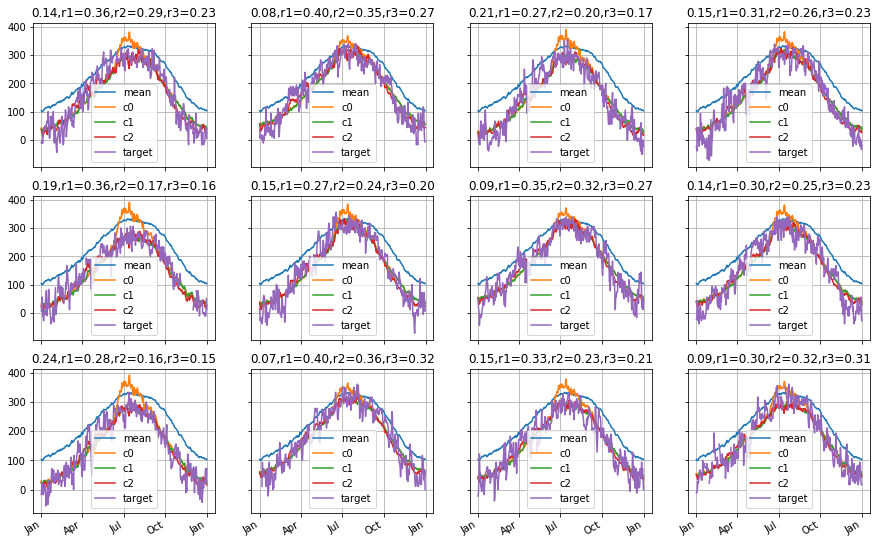

In [35]:
plot_recon_grid(rows)

In [36]:
df3=df3.filter(df3.res_3<0.4).sort(df3.coeff_3,ascending=False)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+-------------------+-------------------+-------------------+-------------------+
|           res_mean|              res_1|              res_2|              res_3|
+-------------------+-------------------+-------------------+-------------------+
|0.18332014403594146|0.26997631985980836|0.17223272008850518| 0.1844530377649018|
|0.20061782464639674|  0.265324342030049|0.20395692923462874|0.19344356655787767|
| 0.2453976226419316| 0.3344458247648398| 0.1887805610677031|0.17949007152295954|
| 0.1830335207950194|0.38296716025325334|0.17682649162527223|0.16700578106793332|
+-------------------+-------------------+-------------------+-------------------+
only showing top 4 rows



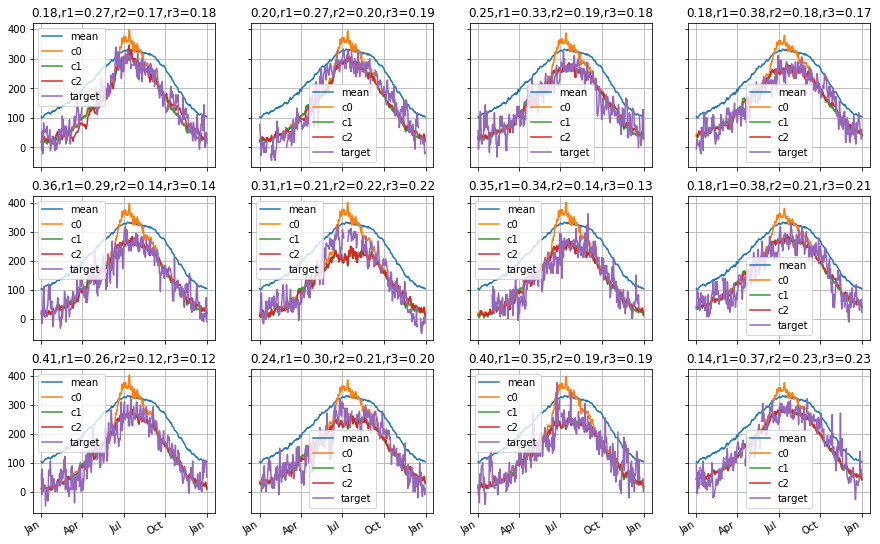

In [37]:
plot_recon_grid(rows)

In [24]:
df3=df3.sort(df3.res_1,ascending=False)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+--------------------+------------------+------------------+------------------+
|            res_mean|             res_1|             res_2|             res_3|
+--------------------+------------------+------------------+------------------+
|0.026319104016279366|1.3694385527067756|1.5116428715773425| 1.446759275632921|
|0.026665234975030806|1.3339373787519062| 1.328664165680809|1.4399111183881304|
|0.026347180990659483| 1.270266631099604|1.2721067342474737|1.5086175765146401|
| 0.03429660949553012|1.1610267088613901|1.3705693911423922|1.4578789201182012|
+--------------------+------------------+------------------+------------------+
only showing top 4 rows



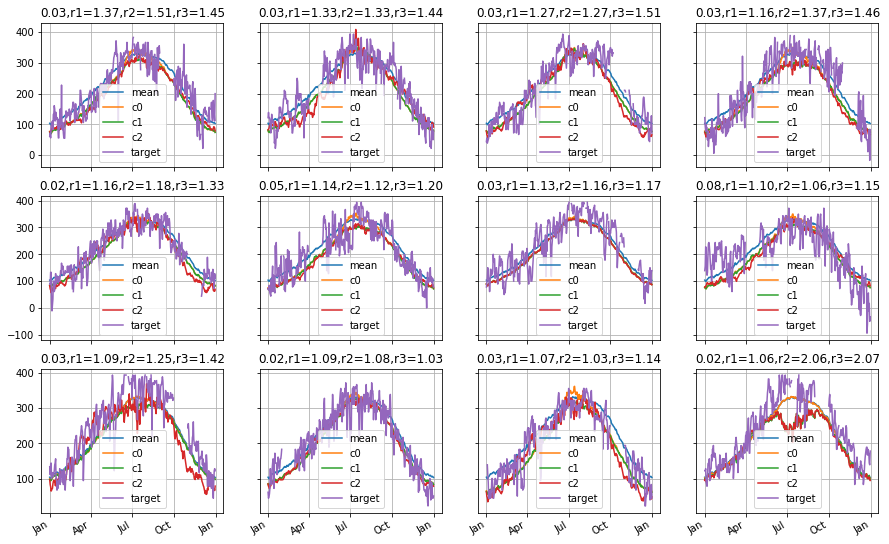

In [25]:
plot_recon_grid(rows)

In [26]:
df3=df3.sort(df3.res_1)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+-------------------+-------------------+-------------------+-------------------+
|           res_mean|              res_1|              res_2|              res_3|
+-------------------+-------------------+-------------------+-------------------+
| 0.2448158585390374|0.19888894656509756|0.13872078119482792|0.13854781180958717|
|0.31299076040626533|0.20526736970849688|0.22068121239893376|0.22330479599183045|
|0.20952937152063295|0.22407226769797542|0.14877853284989948| 0.1487523073224034|
|0.22102245166771517|0.22713588718050667|0.17346305983568816| 0.1698114513796056|
+-------------------+-------------------+-------------------+-------------------+
only showing top 4 rows



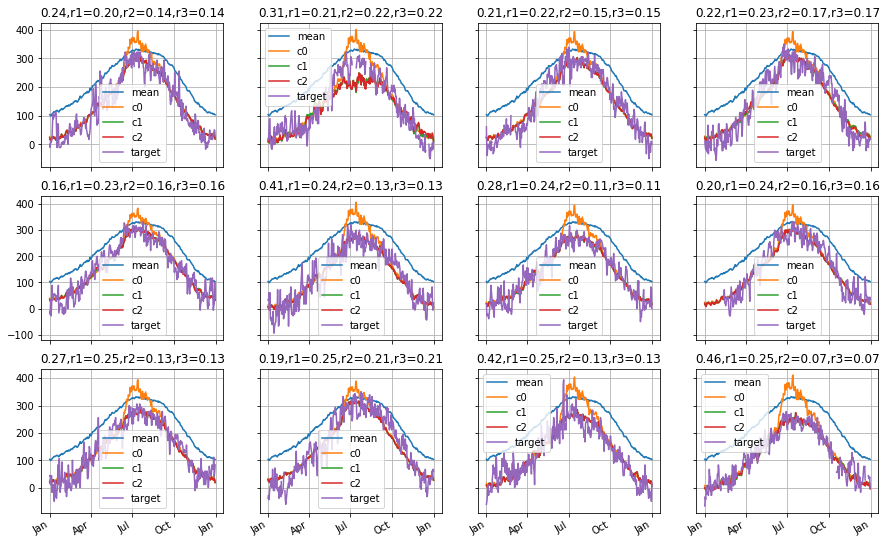

In [27]:
plot_recon_grid(rows)

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

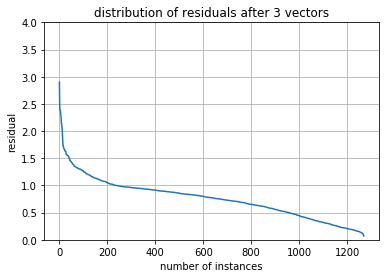

In [33]:
res3=df3.select('res_3').collect()
R3=[r['res_3'] for r in res3]
plot(R3)
title('distribution of residuals after 3 vectors')
xlabel('number of instances')
ylabel('residual')
ylim([0,4])
grid()

In [34]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [28]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
2.9M	../../Data/Weather/US_Weather_SSSSSSBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB.parquet
3.9M	../../Data/Weather/decon_BBBSBBBB_PRCP.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.1M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.1M	../../Data/Weather/decon_SSSSSSBB_PRCP.parquet
